In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed
import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-2b95b306fbfc>:13: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  aqua_globals.random_seed = seed


In [2]:
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.circuit.library import TwoLocal
import functools

In [3]:
os_dataset = pd.read_excel('co2_attainment_OS.xlsx', engine='openpyxl')

os_dataset.head()

,NAMES,MS 1 0%,MS 2 24%,MS 3 0%,ASSIGNMENT 20%,SEM RESULT 15%,TOTAL 59%,OBTAINED FOR 100,Threshold 60%
0,AARTHI.P.,0,20.64,0,20.0,15.0,55.64,94.305085,Y
1,ABDUL KHADI.K.,0,12.00,0,20.0,10.5,42.50,72.033898,Y
2,ABINAYA.N.,0,17.28,0,20.0,13.5,50.78,86.067797,Y
3,AKALYA.M.,0,13.44,0,20.0,12.0,45.44,77.016949,Y
4,ARCHANADEVI@KAMATCHI R.,0,17.76,0,20.0,12.0,49.76,84.338983,Y


In [4]:
df = os_dataset.copy()
df.drop(['NAMES','MS 1 0%','MS 3 0%'], axis = 1, inplace = True)
df['Threshold 60%'].replace(to_replace=['Y', 'N'], value=[1, 0], inplace=True)
df.head()

,MS 2 24%,ASSIGNMENT 20%,SEM RESULT 15%,TOTAL 59%,OBTAINED FOR 100,Threshold 60%
0,20.64,20.0,15.0,55.64,94.305085,1
1,12.00,20.0,10.5,42.50,72.033898,1
2,17.28,20.0,13.5,50.78,86.067797,1
3,13.44,20.0,12.0,45.44,77.016949,1
4,17.76,20.0,12.0,49.76,84.338983,1


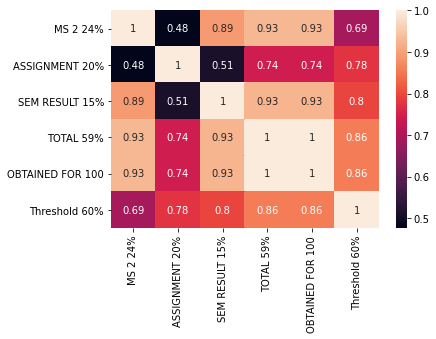

In [5]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot=True)

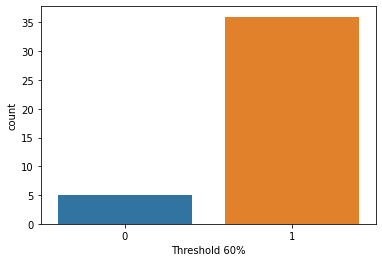

In [6]:
sns.countplot(df['Threshold 60%'])

## Classical ML model

In [7]:
X = df.iloc[:,range(5)].values
y = df.iloc[:,5].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

In [8]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
print("score on test: " + str(lr_classifier.score(X_test, y_test)))
print("score on train: "+ str(lr_classifier.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


In [9]:
from sklearn.naive_bayes import GaussianNB
mnb_classifier = GaussianNB().fit(X_train, y_train)
mnb_classifier.fit(X_train, y_train)
print("score on test: " + str(mnb_classifier.score(X_test, y_test)))
print("score on train: "+ str(mnb_classifier.score(X_train, y_train)))

score on test: 1.0
score on train: 1.0


## QSVM

In [10]:
vals = df[df.columns[:-1]].values

In [11]:
def custom_data_map_func(x):
    """Define a function map from R^n to R.
    
    Args:
        x (np.ndarray): data
    Returns:
        double: the mapped value
    """
    coeff = x[0] if len(x) == 1 else functools.reduce(lambda m, n: m * n, np.pi - x)
    return coeff

In [12]:
train_input = vals[:25]
test_input = vals[25:]

training_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(train_input)):
    if df['Threshold 60%'][i] == 1:
        training_data[1].append(train_input[i].tolist())
    else:
        training_data[0].append(train_input[i].tolist())
        
testing_data = {1:[],0:[]} # 1 == 'A' and 0 == 'B'
for i in range(len(test_input)):
    if df['Threshold 60%'][i] == 1:
        testing_data[1].append(test_input[i].tolist())
    else:
        testing_data[0].append(test_input[i].tolist())

In [13]:
def qsvm_testing_accuracy(training_data, testing_data, feature_dim, reps, entanglement):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
    qsvm = QSVM(feature_map, training_data, testing_data)

    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
    result = qsvm.run(quantum_instance)
    print('Testing Accuracy for reps={} and entanglement={}: '.format(reps, entanglement), result['testing_accuracy'])
    return

In [14]:
lst = ['linear', 'circular', 'full']

feature_dim = 5

for i in range(len(lst)):
    for j in lst:
        qsvm_testing_accuracy(training_data, testing_data, feature_dim, i+1, j)


Testing Accuracy for reps=1 and entanglement=linear:  1.0
Testing Accuracy for reps=1 and entanglement=circular:  1.0
Testing Accuracy for reps=1 and entanglement=full:  1.0
Testing Accuracy for reps=2 and entanglement=linear:  1.0
Testing Accuracy for reps=2 and entanglement=circular:  1.0
Testing Accuracy for reps=2 and entanglement=full:  1.0
Testing Accuracy for reps=3 and entanglement=linear:  1.0
Testing Accuracy for reps=3 and entanglement=circular:  1.0
Testing Accuracy for reps=3 and entanglement=full:  1.0


In [16]:
reps = 1
entanglement = 'linear'
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement=entanglement,  data_map_func=custom_data_map_func)
    
final_qsvm = QSVM(feature_map, training_data, testing_data)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)
result = final_qsvm.run(quantum_instance)
result['testing_accuracy']

1.0

## VQC

In [15]:
from qiskit.aqua.algorithms import VQC

In [17]:
feature_dim = 5

#feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='full')
#feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=2, paulis=['ZZ'])
feature_map = RawFeatureVector(feature_dimension=feature_dim)

vqc = VQC(COBYLA(maxiter=100),
          feature_map,
          TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3),
          training_dataset = training_data,
          test_dataset = testing_data)

result = vqc.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                 shots=1024, seed_simulator=seed, seed_transpiler=seed))

print('Testing accuracy: {:0.2f}'.format(result['testing_accuracy']))
print(result)

Testing accuracy: 1.00
{'num_optimizer_evals': 100, 'min_val': 0.14008625105848552, 'opt_params': array([ 2.00077628,  1.59866153, -0.6452078 , -0.4597867 ,  1.53767441,
        0.34552623, -0.21720021,  3.10867099,  1.24969873, -0.86735358,
        2.20778357, -1.61218392,  0.33370454,  2.33990511,  1.22651301,
        1.36818674, -1.09182547, -2.12149683, -0.63209192, -1.81206169,
        0.53562485, -0.41906733, -0.17671045,  0.36452381]), 'eval_time': 517.2042174339294, 'eval_count': 100, 'training_loss': 0.14008625105848552, 'testing_accuracy': 1.0, 'test_success_ratio': 1.0, 'testing_loss': 0.050626142903388176}


Both QSVM and VQC performed equally well.